# CSEN1095 Data Engineering Course Project

## Overview and Motivation

<p>Mobile applications are used around the world on a daily basis. They are now an integral part of many people's daily lives and provide users with many utilities. Today people download apps for countless purposes, such as education, communication, entertainment, and navigation. Google Play Store is one market for mobile applications. It houses millions of apps, which users can readily download and install on their devices. Not all apps, however, are successful. Many fail at launch or receive poor reviews, which result in poor ratings that send these apps into obscurity. New businesses attempting to penetrate the app market may need information to help them in the decision-making and app-development process. Only extensive statistical analysis can provide such information.</p>
<p>In this project, our goal is to explore some interesting relationships among a subset of the mobile apps on the Google Play Store. Furthermore, we will provide a data cleaning and transformation pipeline that can prepare the data for machine learning algorithms. And finally, we will attempt to predict the apps rating from the other features and properties of the apps.</p>
<p>In our analysis, we have used several python libraries, including Numpy, Pandas, Matplotlib, Seaborn, Pyod and Scikit-Learn. Pandas was used for data storage and manipulation. Matplotlib and Seaborn were used for visualizations. Pyod was used for outlier detection, and Scikit-Learn was used for transformations, pipelining, and machine learning. These tools are imported in the following cells:</p>

In [229]:
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion, Pipeline

In [230]:
%%capture
pip install pyod

In [231]:
%%capture
pip install --upgrade pyod

## Related Work

## Initial Questions

* What is the category with the greatest number of installs?
* What is the category with the highest ratings?
* What is the category with the worst ratings?
* Is there a relationship between category and app size?
* Is there a relationship between category and installs?
* Is there a relationship between installs and number of reviews?
* Is there a relationship between number of reviews and rating?
* Is there a relationship between the rating and number of installs?
* Can we successfully predict the rating of an app from the other attributes of the app?

## The Data 

### Data Loading

The [dataset](https://www.kaggle.com/lava18/google-play-store-apps) used in this project comprises more than 10,000 entries of Google Play Store apps. These apps belong to different categories and have varying popularities. The dataset is available on Kaggle in CSV format. According to the source that provided the data, the dataset was collected through web-scrapping. The Google Play Store was queried to gather the entries. <br><br>
The data is divided over two files. The first file `googleplaystore.csv` is the main dataset, which contains more than 10,000 rows and 13 features. The second file `googleplaystore_user_reviews.csv` contains a collection of reviews along with sentiment analysis data. After examinging the files, we realized that the apps in the first and second file do not correspond to one another. Many apps have no reviews associated with them. Therefore, we decided to focus our work and analysis on the main dataset. <br><br>
First, we read the CSV files and load the data, parsing the `Last Updated` column to the date format:

In [232]:
apps_df = pd.read_csv('./data/googleplaystore.csv', parse_dates=['Last Updated'], infer_datetime_format=True)
user_reviews_df = pd.read_csv('./data/googleplaystore_user_reviews.csv')

<p>Let's first take a look at the main dataset. We print the first five elements: </p>

In [233]:
apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


As shown above, the data consists of 13 features:
 * `App`: the app name.
 * `Category`: a categorical label, which describes which broad category the app belongs to.
 * `Rating`: a continuous variable with a range from 0.0 to 5.0, which describes the average rating the app has received from the users. 
 * `Reviews`: a continuous variable describing the number of reviews that the app received. 
 * `Size`: the size of the app. The suffix M is used for megabytes, while the suffix K is used for kilobytes.
 * `Installs`: a categorical label that describes the number of installs. 
 * `Type`: a label that indicates whether the app is free or paid. 
 * `Price`: the price value for the paid apps. 
 * `Content Rating`: a categorical rating that indicates the age group for which the app is suitable.
 * `Genre`: a semicolon-separated list of genres to which the app belongs.
 * `Last Update`: the date the app was last updated.
 * `Current Version`: the current version of the app as specified by the developers.
 * `Android Version`: the Android operating system the app is compatible with.

<p> Now we take a look at the adjunct reviews data: </p>

In [234]:
user_reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


As shown above, the adjunct review data consists of 5 features:
* `App`: the app name.
* `Translated_Review`: the review text in English.
* `Sentiment`: the sentiment of the review, which can be positive, neutral, or negative.
* `Sentiment_Polarity`: the sentiment in numerical form, ranging from -1.00 to 1.00.
* `Sentiment_Subjectivity`: a measure of the expression of opinions, evaluations, feelings, and speculations.

<p> For now, we will put the review data aside and work with the main dataset. </p>

### Data Cleaning

#### I. Dropping Noisy Entries

Let's start by first checking the values in the <i>Category</i> column.

In [235]:
pd.DataFrame(apps_df['Category'].value_counts(ascending=True)).head(5)

,Category
1.9,1
BEAUTY,53
PARENTING,60
COMICS,60
EVENTS,64


From the above result, we can see that there is a category called `1.9`, which occurs only once. Let's find its corresponding data entry:

In [236]:
apps_df[apps_df['Category'] == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


As we can see in the above result, record 10472 has wrong inputs in almost all of its columns. It is a noisy entry; therefore, we remove it:

In [237]:
apps_df = apps_df.drop(10472)

We also need to remove duplicates, which can result in statistical bias towards certain values. Let's check if we have any duplicated entries:

In [238]:
apps_df.duplicated().sum()

483

There are over 400 duplicates in the dataset, so we remove them:

In [239]:
apps_df = apps_df.drop_duplicates()
apps_df.duplicated().sum()

0

#### II. Removing `M`, `k`, and `Varies with device` from `Size` column

Next, let's clean the `Size` column. We start by getting the unique values in the column:

In [240]:
apps_df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

Ideally, the `Size` column should be a numerical apporixmation of the actual size of the app, so we must remove the `k` and `M` attached to the end of each entry and replace them with the proper values that they stand for. We will unify the unit of the column to be kilobytes. Therefore, for each entry with `M`, we will multiply its value by 1024. We must also remove the `Varies with device` label, which is not numerical. For now, we will replace it with `NaN`. This will help us impute the values appropriately in the transformations stage.

Running the following cell produces the desried output:

In [241]:
# Removing `M`, Changing Size To KB
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(int(float(value.rstrip('M')) * 1024)) if value[-1] == 'M' else value
)

# Removing `k`
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        str(value.rstrip('k')) if value[-1] == 'k' else value
)

# Setting `Varies with device` to NaN
apps_df['Size'] = apps_df['Size'].map(
    lambda value :
        np.nan if value == 'Varies with device' else value
)

#### III. Removing `+` and  `,` from `Installs` column

Let's begin by printing the value counts in the `Installs` column:

In [242]:
pd.DataFrame(apps_df['Installs'].value_counts())

,Installs
"1,000,000+",1488
"10,000,000+",1132
"100,000+",1129
"10,000+",1033
"1,000+",890
100+,710
"5,000,000+",683
"500,000+",517
"50,000+",474
"5,000+",469


Although the `Installs` column is already categorical, we prefer to remove the `+` and `,` from its values. This will collapse the `0+` and `0` category together and remove the overlap betweent the two. Running the cell below will produce the desired output:

In [243]:
# Removing `+`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        value.rstrip('+')
)

# Removing `,`
apps_df['Installs'] = apps_df['Installs'].map(
    lambda value :
        ''.join(value.split(','))
)

Next, we combine `0`, `1`, and `5` into the `0` category. Our assumption here is that these categories are almost identical as unsuccessful apps. They contain very few values, so it will be better to combine them all into one.

In [244]:
selector = (apps_df['Installs'] == '1') | (apps_df['Installs'] == '5')
apps_df.loc[selector, ['Installs']] = '0'

pd.DataFrame(apps_df['Installs'].value_counts())

,Installs
1000000,1488
10000000,1132
100000,1129
10000,1033
1000,890
100,710
5000000,683
500000,517
50000,474
5000,469


#### IV. Removing `$` from `Price` column

To clean the `Price` column, we begin by examining the unique values:

In [245]:
apps_df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

Since this column is numerical in nature, we clean it by removing the `$` sign from all its entries using the following code:

In [246]:
# Removing `$`
apps_df['Price'] = apps_df['Price'].map(
    lambda value :
        value.lstrip('$')
)

#### V. Changing Columns To Numeric

Now, let's examine the statistics of the numerical columns:

In [247]:
apps_df.describe()

,Rating
count,8892.000000
mean,4.187877
std,0.522377
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


The `describe()` method did not print values for the columns we preprocessed because they are all stored as strings. We need to convert the values to numbers:

In [248]:
# Changing Values From String To Numeric in `Rating` Column
apps_df['Rating'] = pd.to_numeric(apps_df['Rating'])

# Changing Values From String To Numeric In `Reviews` Column
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'])

# Changing Values From String To Numeric in `Size` Column
apps_df['Size'] = pd.to_numeric(apps_df['Size'])

# Changing Values From String To Numeric in `Installs` Column
apps_df['Installs'] = pd.to_numeric(apps_df['Installs'])

# Changing Values From String To Numeric in `Price` Column
apps_df['Price'] = pd.to_numeric(apps_df['Price'])

Now we print the statistics again:

In [249]:
apps_df.describe()

,Rating,Reviews,Size,Installs,Price
count,8892.000000,1.035700e+04,8831.000000,1.035700e+04,10357.000000
mean,4.187877,4.059046e+05,21798.151682,1.415776e+07,1.030800
std,0.522377,2.696778e+06,23081.680751,8.023955e+07,16.278625
min,1.000000,0.000000e+00,8.500000,0.000000e+00,0.000000
25%,4.000000,3.200000e+01,4812.000000,1.000000e+03,0.000000
50%,4.300000,1.680000e+03,13312.000000,1.000000e+05,0.000000
75%,4.500000,4.641600e+04,29696.000000,1.000000e+06,0.000000
max,5.000000,7.815831e+07,102400.000000,1.000000e+09,400.000000


#### VI. Checking for Missing Values

Now that we have made sure that the numerical columns are formatted properly. Let's check for missing values:

In [250]:
missing_count = apps_df.isna().sum()

missing_count

App                  0
Category             0
Rating            1465
Reviews              0
Size              1526
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

From the results shown above, we can tell that `Rating`, `Size`, `Type`, `Current Ver`, and `Android Ver` all contain missing values. They need to be cleaned somehow, so this will be our next focus.

#### VII. Handling Missing Values in the `Type` Column

There is a direct correspondence between the `Type` and `Price` columns. Therefore, we will replace the `NaN` values in the `Type` column with the labels `Free` and `Paid` based on the value in the `Price` column.

In [251]:
pd.DataFrame(apps_df['Type'].value_counts())

,Type
Free,9591
Paid,765


In [252]:
# Replacing NaN
apps_df['Type'] = np.where(apps_df['Price'] == 0, 'Free', 'Paid')

#### VIII. Handling Missing Values in the `Current Ver` Column

The versioning of an app is arbitrary, and different developers follow different versioning schemes. Since there is no reliable method to discover the version of the app, we will replace the `NaN` values with `1.0`. This will change only 8 records, so it will not produce any statistical bias.

In [253]:
# Replacing `NaN`
apps_df['Current Ver'] = apps_df['Current Ver'].fillna('1.0')

#### IX. Handling Missing Values in the `Android Ver` Column

We will replace the `NaN` values with the most repeated value in the `Android Ver` Column. We are assuming that the apps will run on the most popular or prevalent Android operating system. Since there are only 2 missing elements, this should not produce any statistical bias.

In [254]:
pd.DataFrame(apps_df['Android Ver'].value_counts()).head()

,Android Ver
4.1 and up,2379
4.0.3 and up,1451
4.0 and up,1337
Varies with device,1221
4.4 and up,894


In [255]:
# Replacing `NaN`
apps_df['Android Ver'] = apps_df['Android Ver'].fillna(apps_df['Android Ver'].value_counts().idxmax())

We verify that the count of the most popular Android Version increased:

In [256]:
pd.DataFrame(apps_df['Android Ver'].value_counts()).head()

,Android Ver
4.1 and up,2381
4.0.3 and up,1451
4.0 and up,1337
Varies with device,1221
4.4 and up,894


#### X. Handling Missing Values in `Size`

We will impute the missing values in `Size` using a mean imputer. The mean, however, will be calculated over the apps that belong to the same category. This method assumes that apps that belong to the same category might share some properties, including size. We believe that this imputation would be better than a mean imputation over the entire dataset. For example, games tend to have bigger sizes than other apps.

The following code performs the desired imputation:

In [257]:
mean_sizes = apps_df.groupby('Category').mean()['Size']

apps_df.loc[apps_df['Size'].isna(), 'Size'] = mean_sizes[apps_df.loc[apps_df['Size'].isna(), 'Category'].values].values

#### XI. Dropping the the missing `Rating` values

Since one of our goals is to predict the `Rating` values, we will not apply any preprocessing steps to this column and simply drop the missing values:

In [258]:
apps_df = apps_df.dropna(subset=['Rating'])

#### XII. Re-Check for Missing Values

Finally, we confirm that we have handled all missing values:

In [259]:
missing_count = apps_df.isna().sum()

missing_count

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

#### XIII. Outlier Detection

Using 6 different outlier detection algorithms, we will attempt to detect outliers in our dataset. This detection will be based on the numerical attributes of our data. We begin by importing and creating the detectors from the Pyod library:

In [260]:
from pyod.models.hbos import HBOS 
from pyod.models.cblof import CBLOF 
from pyod.models.knn import KNN 
from pyod.models.lof import LOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.iforest import IForest

outliers_fraction = 0.01

detectors = [
    HBOS(contamination=outliers_fraction),
    LOF(contamination=outliers_fraction),
    CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=42),
    KNN(contamination=outliers_fraction),
    KNN(method='mean',contamination=outliers_fraction),
    FeatureBagging(contamination=outliers_fraction, random_state=42),
    IForest(contamination=outliers_fraction, behaviour='new', random_state=42)
]

Next, we extract the numerical attributes and create a new DataFrame that includes them:

In [261]:
columns_to_drop = [
    'App', 'Rating', 'Current Ver', 'Last Updated', 
    'Android Ver', 'Category', 'Type', 'Content Rating', 'Genres'
]
outlier_detection_df = apps_df.copy()
outlier_detection_df.drop(columns=columns_to_drop, inplace=True)
outlier_detection_df.head()

,Reviews,Size,Installs,Price
0,159,19456.0,10000,0.0
1,967,14336.0,500000,0.0
2,87510,8908.0,5000000,0.0
3,215644,25600.0,50000000,0.0
4,967,2867.0,100000,0.0


We apply the outlier detection algorithms and union all the outlier detectors' results to get all the outliers:

In [262]:
outlier_mask = []
for detector in detectors:
    print(detector)
    detector.fit(outlier_detection_df)
    predictions = detector.predict(outlier_detection_df)
    print('Found ', apps_df[predictions == 1].shape[0], ' outliers.')
    if(len(outlier_mask) == 0):
        outlier_mask = (predictions == 1)
    else:
        outlier_mask = outlier_mask | (predictions == 1)
    print('----------------------------')

HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)
Found  20  outliers.
----------------------------
LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, p=2)
Found  80  outliers.
----------------------------
CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)
Found  89  outliers.
----------------------------
KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
Found  63  outliers.
----------------------------
KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
Found  52  outliers.
----------------------------
FeatureBagging(base_estimator=None, bootstrap_features=False,
        check_detector=Tr

We print the total number of outliers:

In [263]:
outlier_mask.sum()

245

We remove them into a special dataframe:

In [264]:
outliers_df = apps_df[outlier_mask].copy()
outliers_df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
152,Google Play Books,BOOKS_AND_REFERENCE,3.9,1433233,13505.617347,1000000000,Free,0.0,Teen,Books & Reference,"August 3, 2018",Varies with device,Varies with device
331,"Best Wallpapers Backgrounds(100,000+ 4K HD)",COMICS,4.7,3596,7987.000000,10000,Free,0.0,Teen,Comics,"June 16, 2018",1.01,4.0.3 and up
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,11936.900000,1000000000,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,11936.900000,1000000000,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,11936.900000,1000000000,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
340,Gmail,COMMUNICATION,4.3,4604324,11936.900000,1000000000,Free,0.0,Everyone,Communication,"August 2, 2018",Varies with device,Varies with device
341,Hangouts,COMMUNICATION,4.0,3419249,11936.900000,1000000000,Free,0.0,Everyone,Communication,"July 21, 2018",Varies with device,Varies with device
342,Viber Messenger,COMMUNICATION,4.3,11334799,11936.900000,500000000,Free,0.0,Everyone,Communication,"July 18, 2018",Varies with device,Varies with device
347,imo free video calls and chat,COMMUNICATION,4.3,4785892,11264.000000,500000000,Free,0.0,Everyone,Communication,"June 8, 2018",9.8.000000010501,4.0 and up
378,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,40960.000000,500000000,Free,0.0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up


Through this step we have discovered apps we are all familiar with. We can already see `Google Play Books`, `Messenger`, `WhatsApp Messenger`, and `Google Chrome` in the above list. The outliers represent extremely successful or unsuccessful apps and deserve special treatment and analysis. But we will continue to focus on the main dataset, assuming that we are interested in the "average" Google Play Store app.

And we remove the outliers from the original dataframe:

In [265]:
apps_df = apps_df[~outlier_mask]
apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19456.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14336.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8908.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25600.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2867.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Exploratory Data Analysis

In this part of the notebook, we will take a closer look at the data and attempt to answer the questions that we had stated in the beginning of this notebook. We begin by checking the distribution of the values in some of the columns of the dataset.

### Data Distributions

#### I. `Rating` Column

We plot a histogram of the `Rating` column:

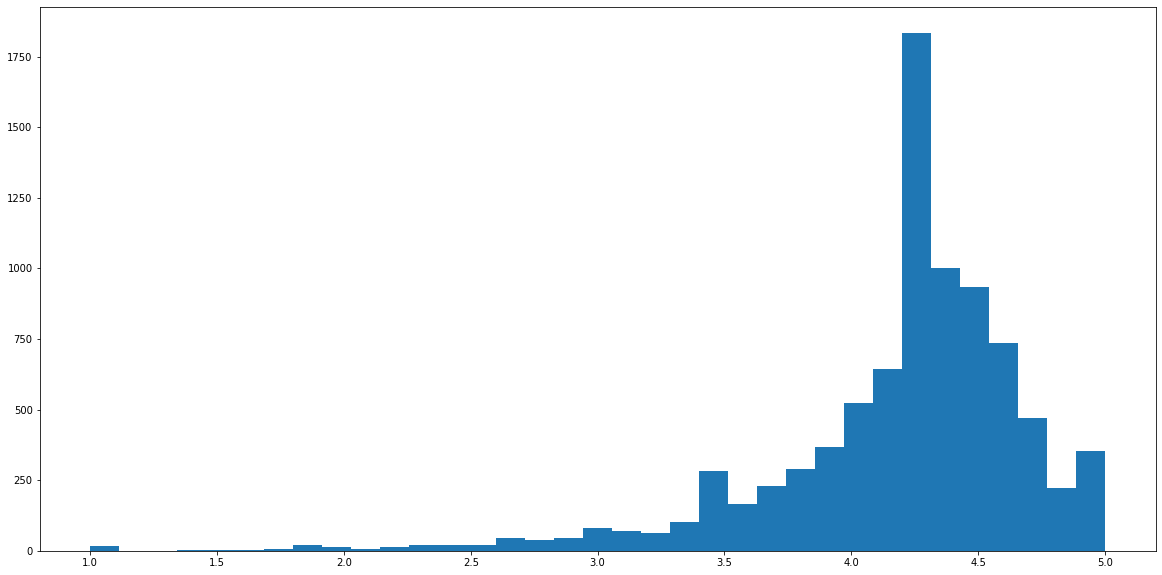

In [266]:
_ = apps_df['Rating'].hist(grid = False, figsize=(20,10), bins = 35)

From the histogram shown above, we can see that the ratings have the bell-shape of the normal distribution. The distribution, however, is skewed to the left. There are more positive ratings than negative ones. Therefore, we conclude that the majority of the apps in the dataset have a good rating. Furthermore, we can see that most apps have a rating between 4.0 and 4.5. We cannot apply any transformations on the `Rating` column, so these observations are only to be noted.

#### II. `Reviews` Column

We plot a histogram of the `Reviews` column:

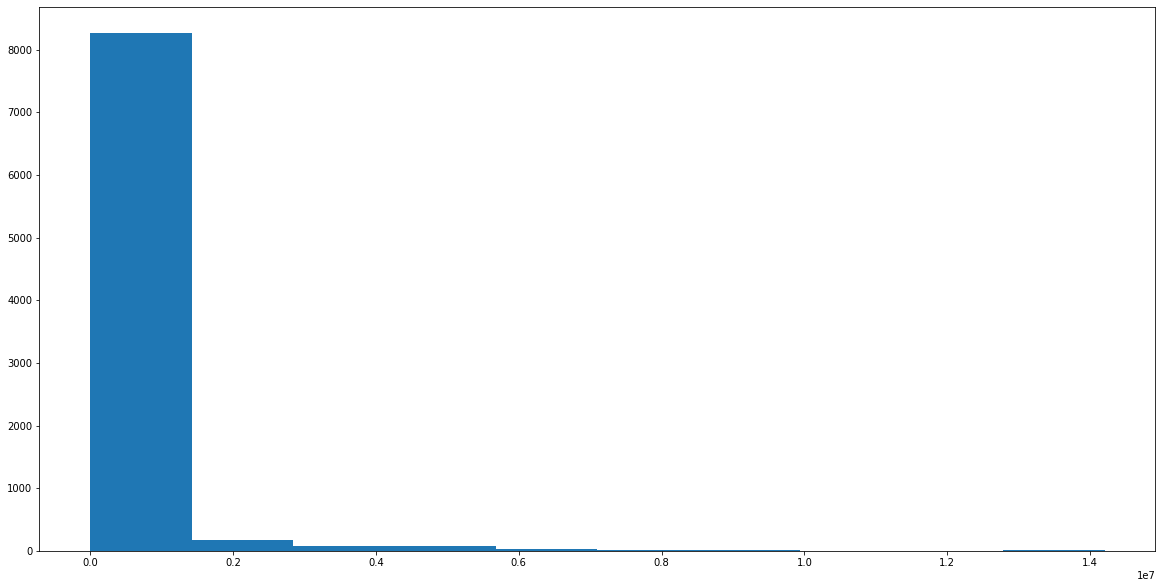

In [273]:
_ = apps_df['Reviews'].hist(grid = False, figsize=(20,10), bins = 10)

The bar histogram above tells us that most of the apps received relatively few reviews but does not allow us to examine the distribution properly. Therefore, we will plot the line histogram:

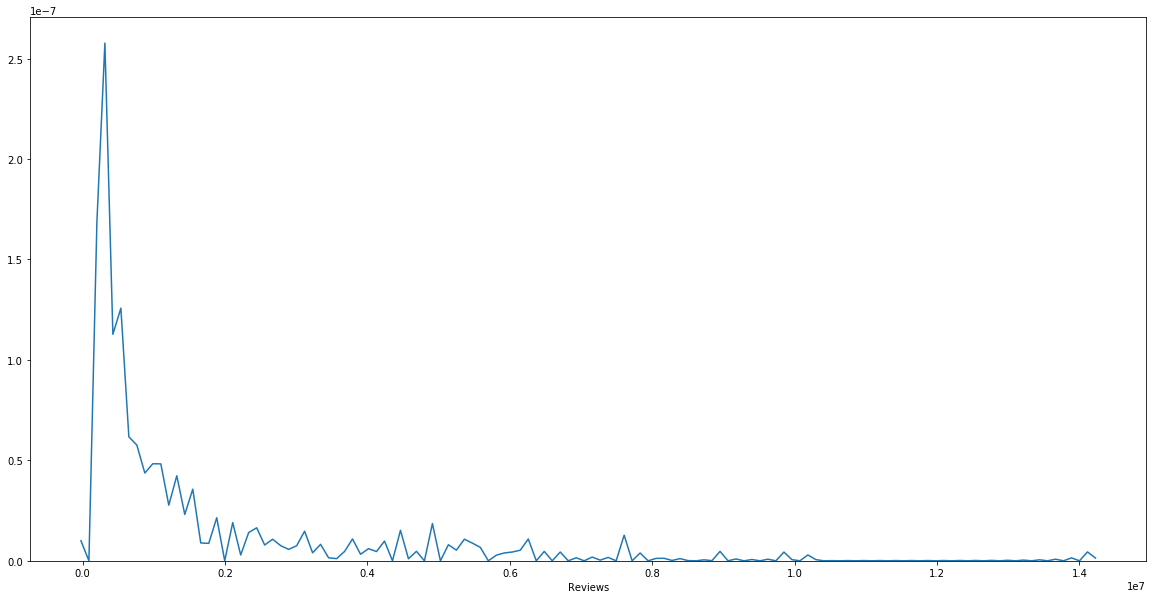

In [274]:
plt.figure(figsize=(20,10))
sns.distplot(apps_df['Reviews'], hist=False)
plt.show()

We print the column statistics to understand why we obtained this skewed visualization:

In [275]:
apps_df['Reviews'].describe()

count    8.647000e+03
mean     2.518700e+05
std      9.672834e+05
min      1.000000e+00
25%      1.540000e+02
50%      4.326000e+03
75%      6.363200e+04
max      1.420189e+07
Name: Reviews, dtype: float64

From the statistics, we can tell that 50% of the apps received reviews in the order of $10^3$, and this value is far lower than the maximum, which is in millions. Therefore, there is very high disparity in the `Reviews` column even after the removal of outliers. This attribute will need to be scaled properly before it is fed to ML algorithms.

#### III. `Size` Column

We plot the distribution histogram for the `Size` column:

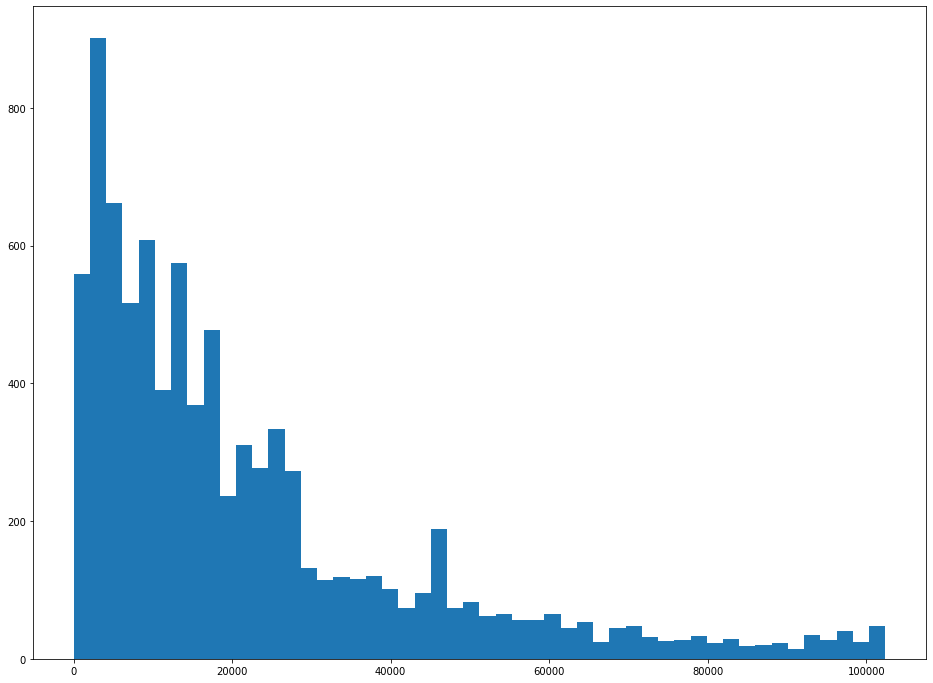

In [309]:
_ = apps_df['Size'].hist(grid = False, figsize=(16,12), bins = 50)

As shown above, the apps in the dataset tend to be small in size. This reflects the design choice of making apps small in size to run on mobile phones.

#### IV. `Installs` Column

Since `Installs` is an ordinal categorical attribute, we provide it with special treatment. Rather than relying on the built-in histogram method, which will assume that the variable is continuous, we will manually count the values and display them:

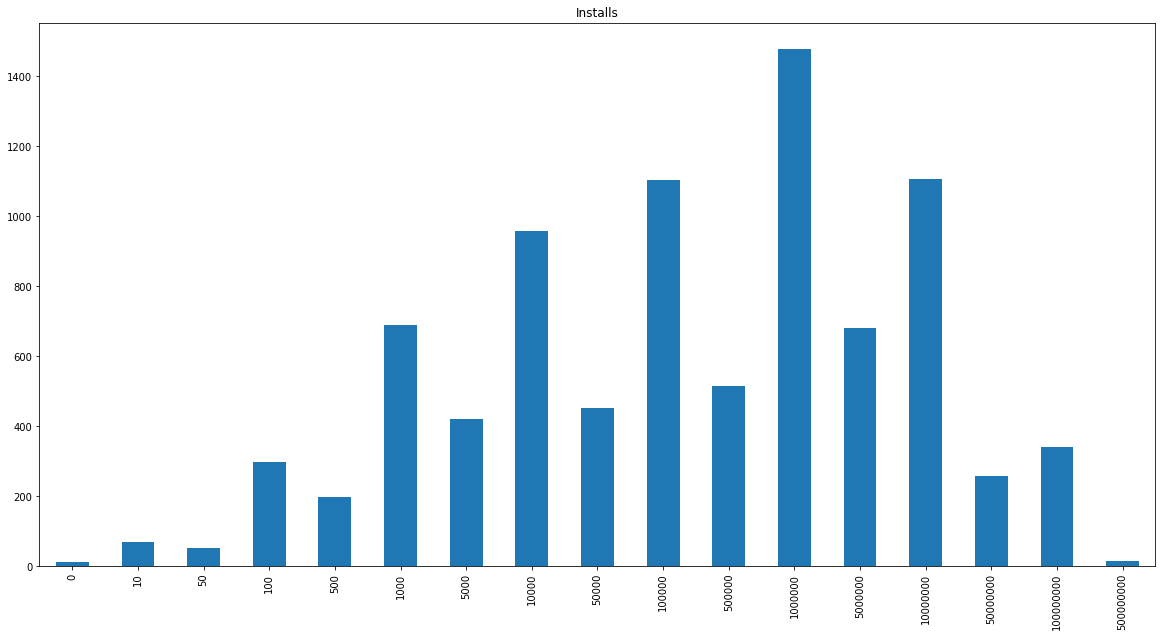

In [307]:
_ = apps_df['Installs'].value_counts().sort_index().plot(kind='bar', figsize=(20,10), title="Installs")

We notice an alternating pattern in the heights of the bars in the chart, especially in the middle area. What is an apporpriate explanation for this seemingly strange pattern?

Let's take a look at the x-labels of the alternating high and low columns. The high bars' labels: `100`, `1000`, `10000`, `100000`,`1000000`. The low bars' labels: `500`, `5000`, `50000`, `500000`. Remember that a label `x` mean `more than x installs`. From these facts, we can make the following observations:
* Most apps in the range \[100-1000( installs have less than 500 installs.
* Most apps in the range \[1000-10000( installs have less than 5000 installs.

And so on for the other values.

This is one possible explanation for meaning of the pattern, but we still do not know why it occurs. It is possible that the data retrieval method, which was used to create the dataset, is behind this method. It is also possible that apps that cross the $5 \times 10^x$ threshold gain more users, grow more quickly (favored by the Play Store search algorithm), and reach the $10^x$ threshold faster. We cannot know for sure from the data alone.

### Seeking Answers

Now that we have examined the distribution of some interesting attributes in the dataset, we begin our search for answers in our data. In this section, we use visualizations and statistical methods to answer as many of our intial questions as possible before we construct the data pipeline. We answer our questions after the exclusion of the outliers.

* What are the categories with the greatest and lowest average number of installs respectively?
* What are the categories with the highest and lowest average ratings respectively?
* Is there a relationship between category and app size?
* Is there a relationship between category and installs?
* Is there a relationship between installs and number of reviews?
* Is there a relationship between number of reviews and rating?
* Is there a relationship between the rating and number of installs?
* Can we successfully predict the rating of an app from the other attributes of the app?

#### What are the categories with the greatest and lowest average number of installs respectively?

This question can also be rephrased as: What are the categories with the biggest and smallest market segments? Results can be used to identify saturated market segments and niches. We group by `Category` and aggregate the `Installs` using the `mean` function. Then we identify the biggest and smallest market segments respectively:

Category with the most installs:  PRODUCTIVITY
Category with the least installs:  MEDICAL


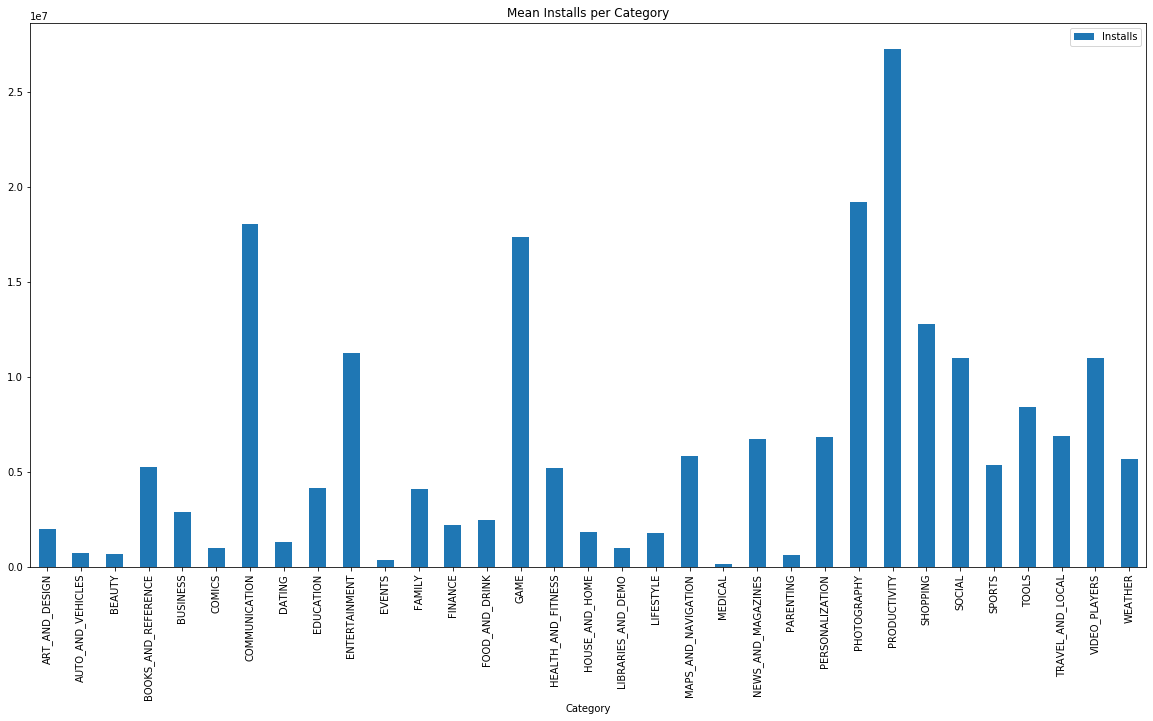

In [353]:
mean_installs_per_category = apps_df.groupby('Category').agg({'Installs': 'mean'})

mean_installs_per_category.plot(
    kind='bar',
    figsize=(20,10), 
    title='Mean Installs per Category',
    sort_columns=True
)

print('Category with the most installs: ', mean_installs_per_category.idxmax().values[0])
print('Category with the least installs: ', mean_installs_per_category.idxmin().values[0])

#### What are the categories with the highest and lowest average ratings respectively?

We answer this question in the same way we answered the previous one:

Category with the most ratings:  EVENTS
Category with the least ratings:  DATING


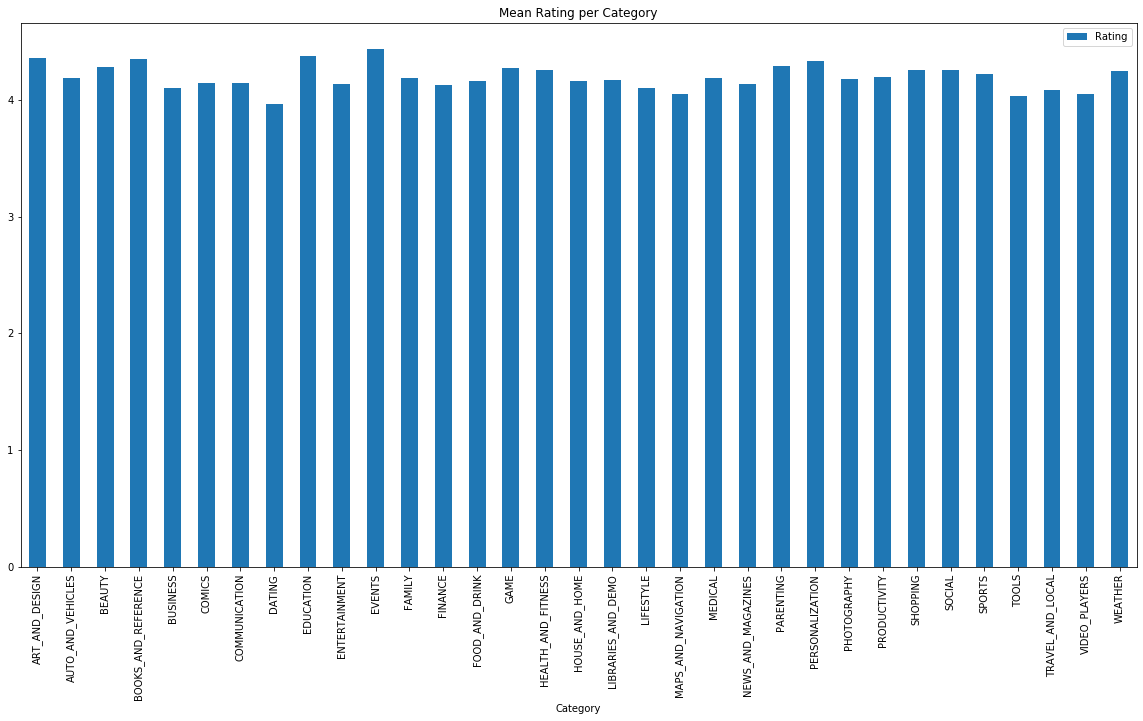

In [354]:
mean_rating_per_category = apps_df.groupby('Category').agg({'Rating': 'mean'})
mean_rating_per_category.plot(
    kind='bar',
    figsize=(20,10), 
    title='Mean Rating per Category',
    sort_columns=True
)

print('Category with the most ratings: ', mean_rating_per_category.idxmax().values[0])
print('Category with the least ratings: ', mean_rating_per_category.idxmin().values[0])

We note that all the categories have similar ratings on average, but it seems that people liked apps in the `DATING` category the least.

### I. Relation between `Category` & mean of `Size` Columns

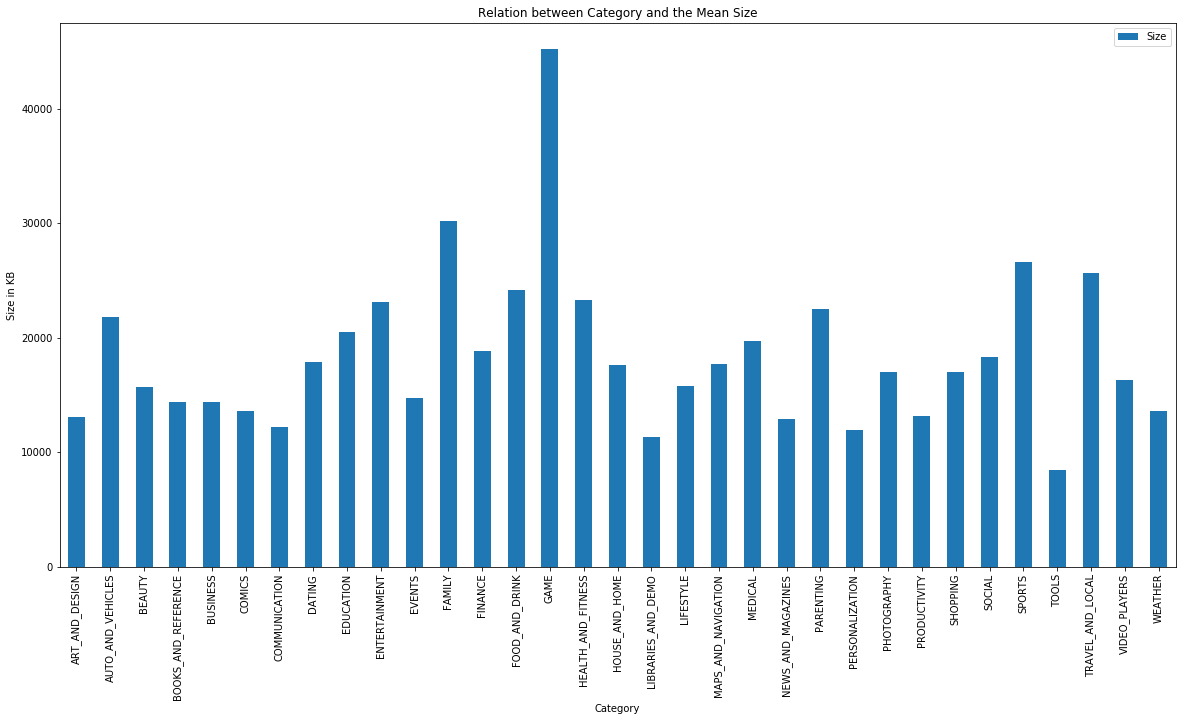

In [321]:
_ = apps_df.groupby('Category').agg({'Size': 'mean'}).plot(kind='bar', figsize=(20,10))
_ = plt.ylabel('Size in KB')
_ = plt.title('Relation between Category and the Mean Size')

### II. Relation between `Category` & mean of `Installs` Columns

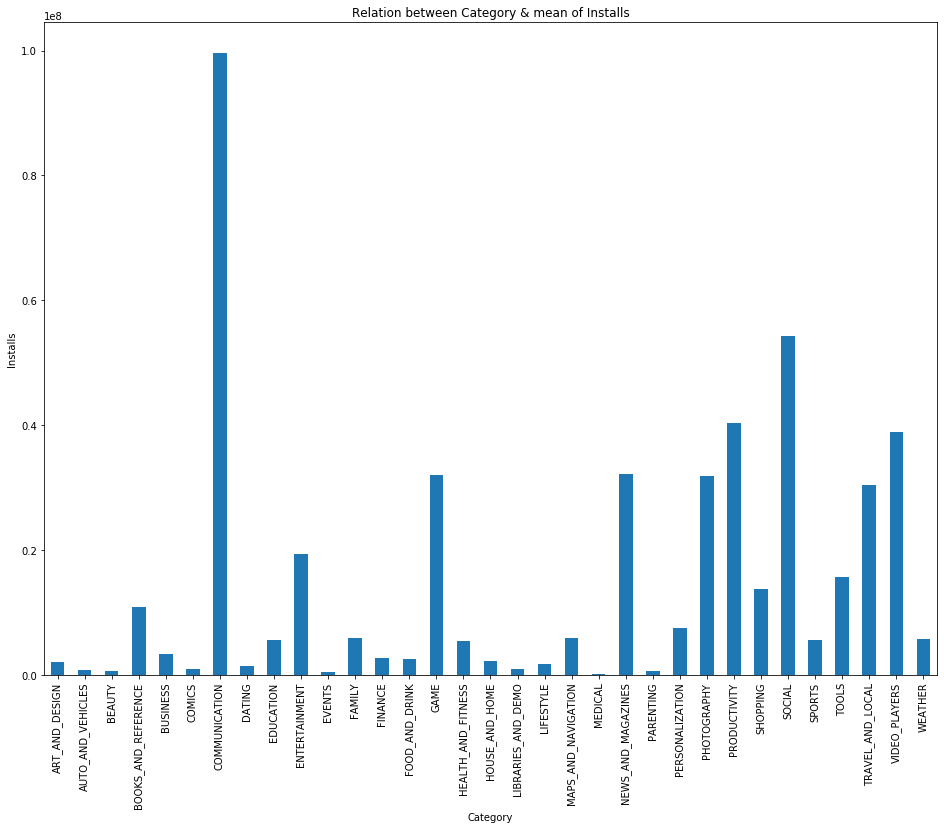

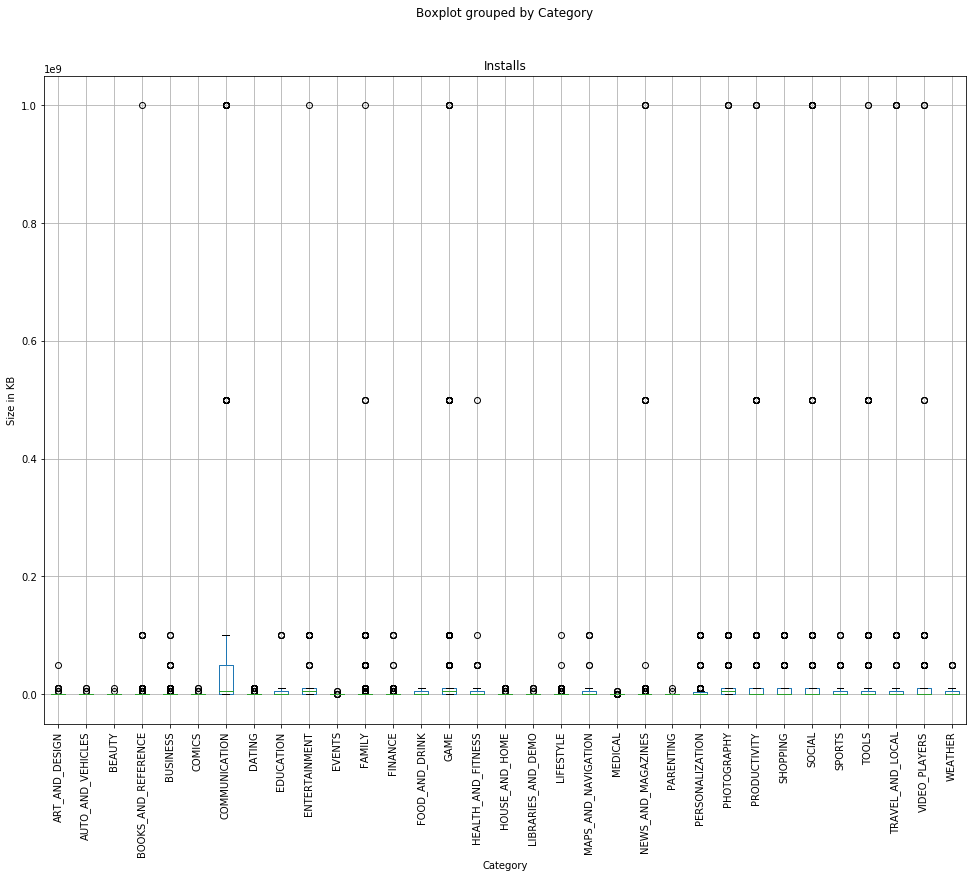

In [37]:
_ = apps_df.groupby('Category')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Category & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Category', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### III. Relation between `Type` & mean of `Installs` Columns

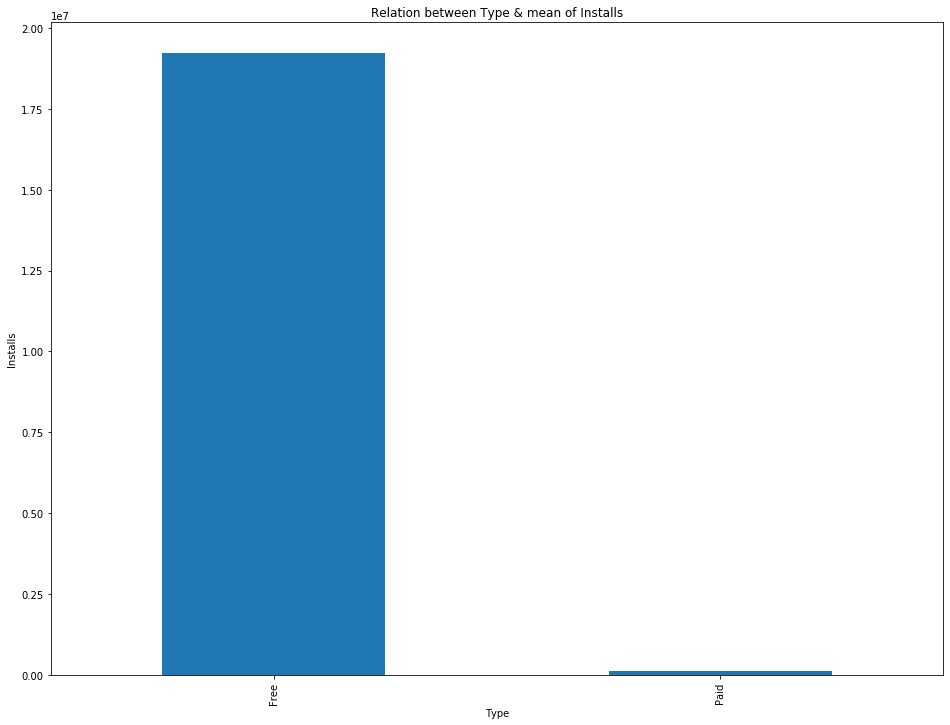

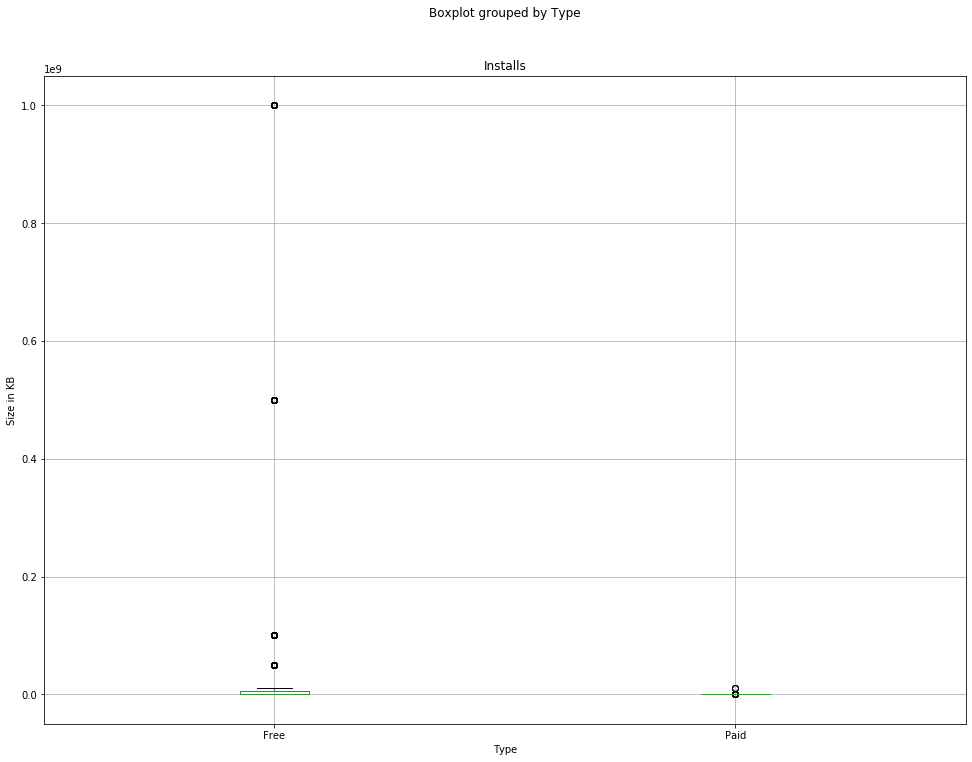

In [38]:
_ = apps_df.groupby('Type')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Type & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Type', figsize=(16,12))
_ = plt.ylabel('Size in KB')

### IV. Relation between `Rating` & mean of `Reviews` Columns

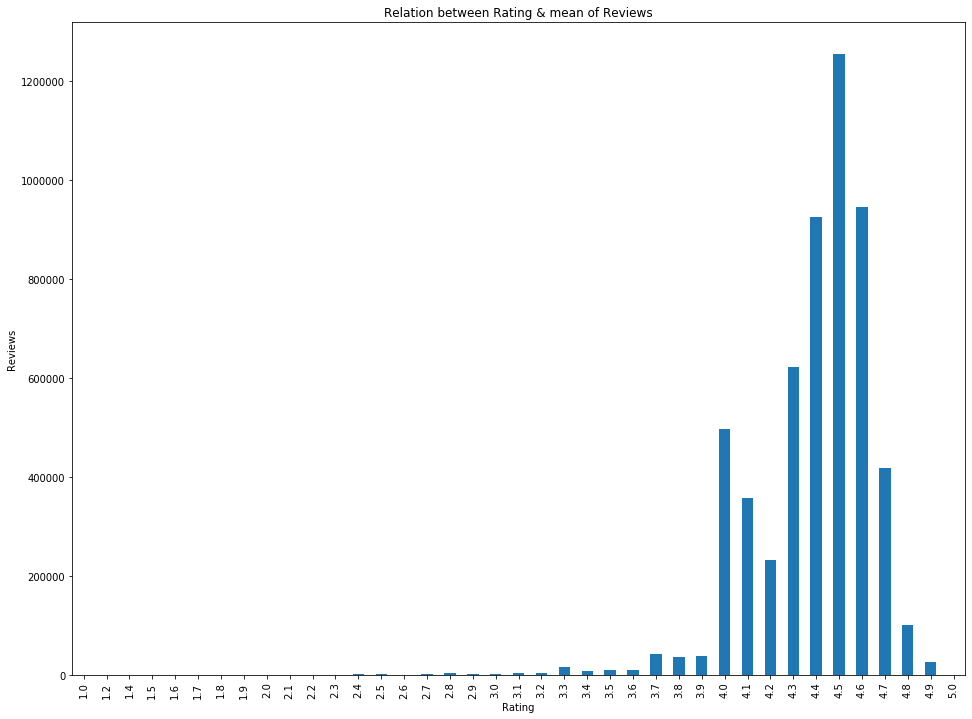

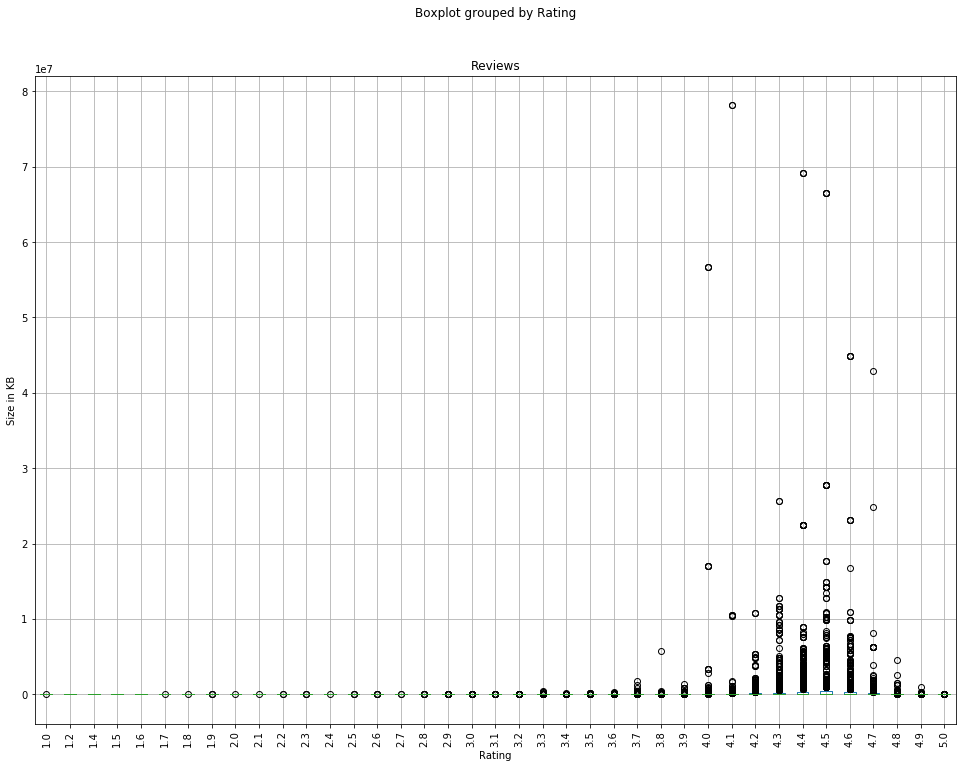

In [39]:
_ = apps_df.groupby('Rating')['Reviews'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Reviews')
_ = plt.title('Relation between Rating & mean of Reviews')

_ = apps_df.boxplot(column='Reviews', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Size in KB')

### V. Relation between `Rating` & mean of `Installs` Columns

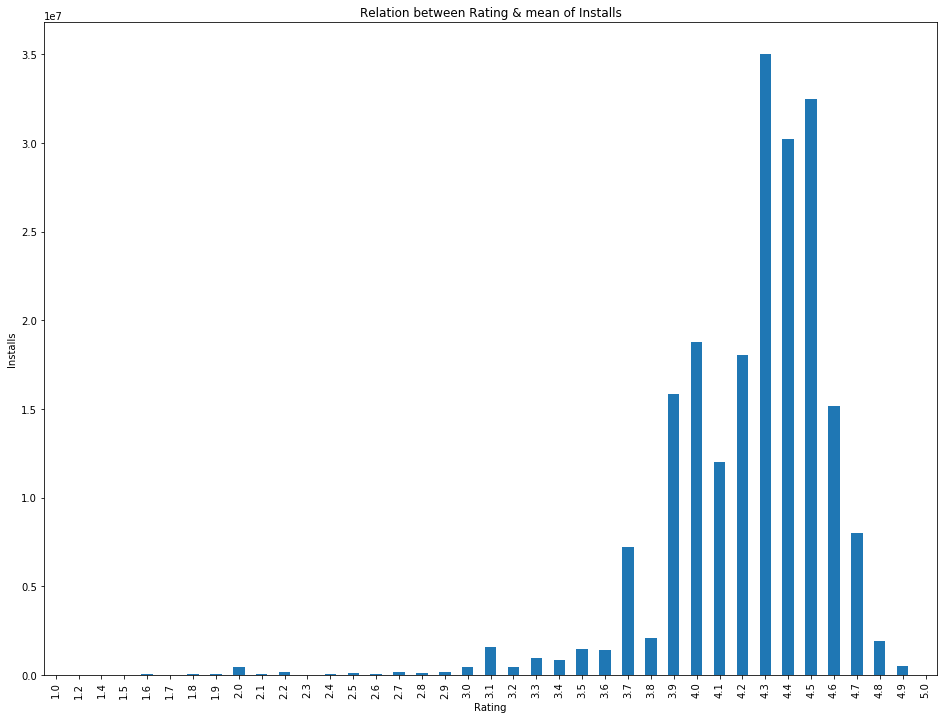

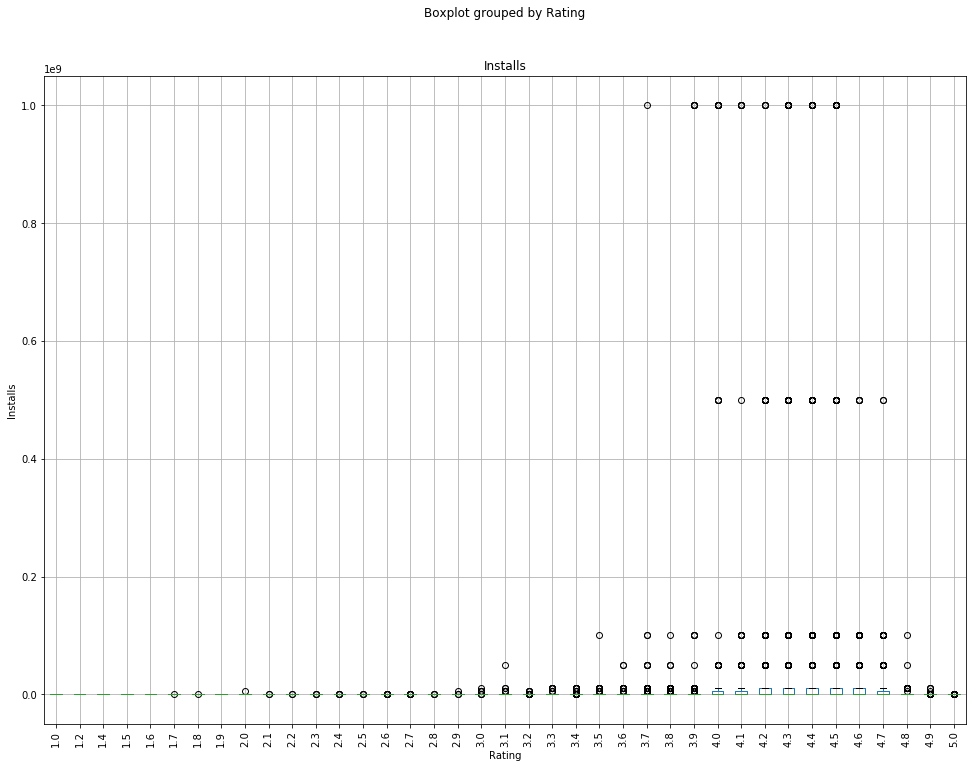

In [40]:
_ = apps_df.groupby('Rating')['Installs'].mean().plot(kind='bar', figsize=(16,12))
_ = plt.ylabel('Installs')
_ = plt.title('Relation between Rating & mean of Installs')

_ = apps_df.boxplot(column='Installs', by='Rating', figsize=(16,12), rot = 90)
_ = plt.ylabel('Installs')

## C. Correlation Matrix between all numerical columns

#### Scatter Plot

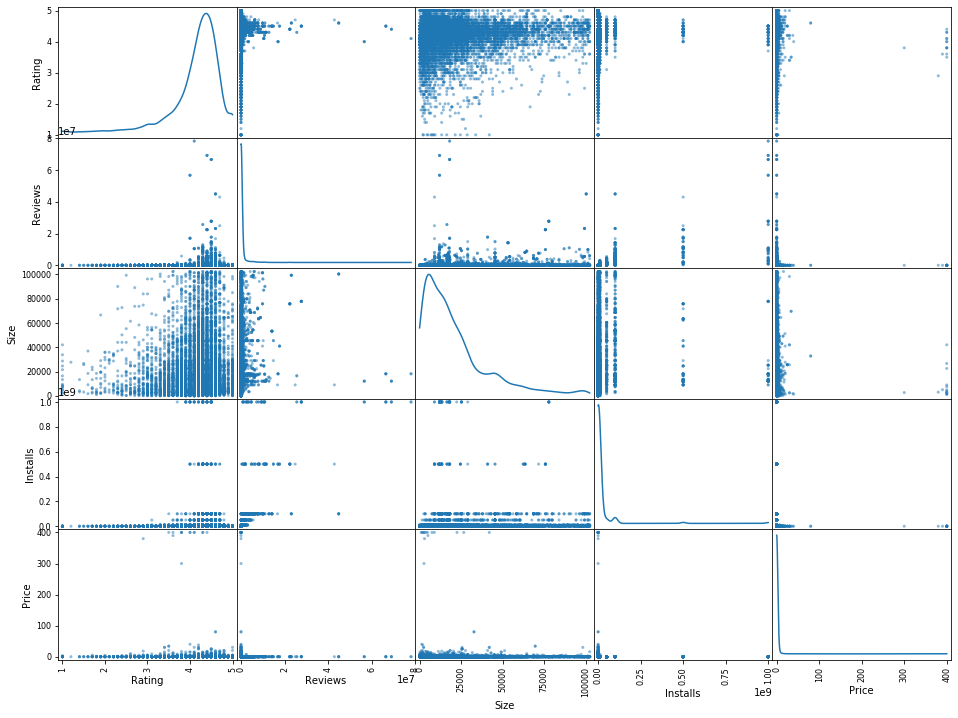

In [41]:
_ = pd.plotting.scatter_matrix(apps_df[apps_df.describe().columns], figsize=(16,12), diagonal='kde')

#### Heat Map

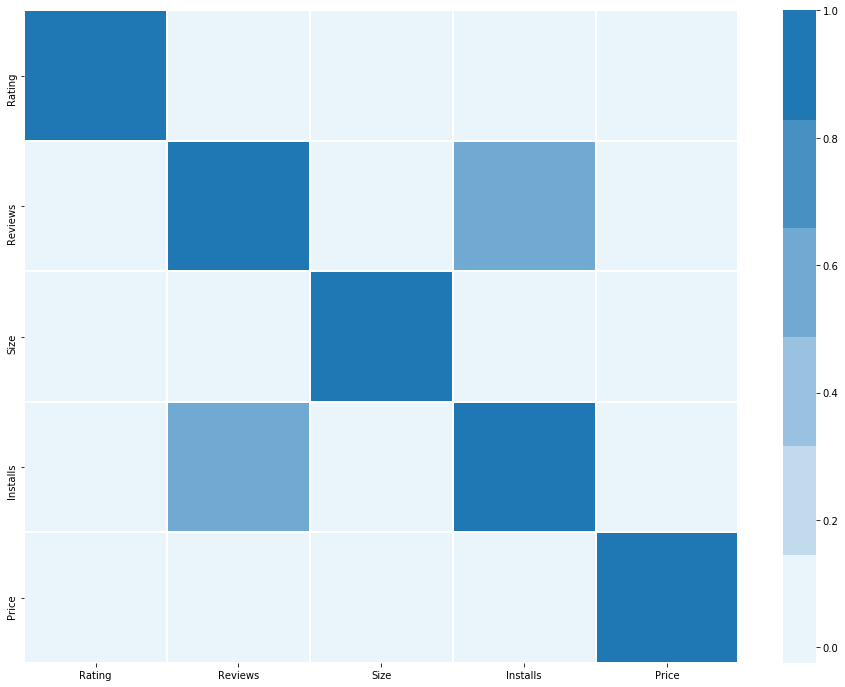

In [42]:
plt.subplots(figsize=(16, 12))
_ = sns.heatmap(
    apps_df[apps_df.describe().columns].corr(),
    cmap = sns.light_palette((31 / 255, 119 / 255, 180 / 255)),
    linewidths = 1
)

# 6. Data Transformation & Feature Engineering

## A. Encoding Data

#### Helper function: One-hot encoder by column name

In [43]:
def one_hot_encode_column(dataframe, column_name, prefix=''):
    dataframe[column_name] = pd.Categorical(dataframe[column_name])
    dummy_values = pd.get_dummies(dataframe[column_name], prefix = column_name + '_' + prefix if prefix != '' else column_name)
    dataframe = pd.concat([dataframe, dummy_values], axis=1)
    dataframe = dataframe.drop(column_name, axis=1)
    
    return dataframe

### I. One-hot encoding the `Type` column

In [44]:
apps_df = one_hot_encode_column(apps_df, 'Type')

apps_df.head()

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Type_Free,Type_Paid
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19456.0,10000,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14336.0,500000,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8908.0,5000000,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1,0
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25600.0,50000000,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1,0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2867.0,100000,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,1,0


### II. One-hot encoding the `Category` column

In [45]:
apps_df = one_hot_encode_column(apps_df, 'Category')

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,...,0,0,0,0,0,0,0,0,0,0


### III. One-hot encoding the `Content Rating` column

In [46]:
apps_df = one_hot_encode_column(apps_df, 'Content Rating')

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Genres,Last Updated,Current Ver,Android Ver,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,...,0,0,0,0,0,1,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,Art & Design,"June 8, 2018",Varies with device,4.2 and up,...,0,0,0,0,0,0,0,0,1,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,...,0,0,0,0,0,1,0,0,0,0


### IV. One-hot encoding the `Genres` column after delimiting values by semicolons

In [47]:
# Collect all unique values in column and join them by a semicolon
joined_unique_values = ';'.join(apps_df['Genres'].unique().tolist())

# Split again using the semicolon and add into a set to remove duplicates
set_of_genres = set(joined_unique_values.split(';'))

# Loop over the set of genres, setting the values to one if the genre name exist in the Genres column
for genre in set_of_genres:
    apps_df['Genre_' + genre] = apps_df['Genres'].map(lambda value: 1 if genre in value.split(';') else 0)

# Drop the Genres column
apps_df = apps_df.drop('Genres', axis=1)

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Last Updated,Current Ver,Android Ver,Type_Free,...,Genre_Racing,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,0.0,"January 7, 2018",1.0.0,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,500000,0.0,"January 15, 2018",2.0.0,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,5000000,0.0,"August 1, 2018",1.2.4,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,0.0,"June 8, 2018",Varies with device,4.2 and up,1,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,100000,0.0,"June 20, 2018",1.1,4.4 and up,1,...,0,0,0,0,0,0,0,0,0,0


### V. Categorise the `Installs` ordinally

In [48]:
ord = OrdinalEncoder()
apps_df['Installs'] = ord.fit_transform(apps_df['Installs'].values.reshape(-1, 1))

apps_df.head()

,App,Rating,Reviews,Size,Installs,Price,Last Updated,Current Ver,Android Ver,Type_Free,...,Genre_Racing,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,8.0,0.0,"January 7, 2018",1.0.0,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967,14336.0,11.0,0.0,"January 15, 2018",2.0.0,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.0,13.0,0.0,"August 1, 2018",1.2.4,4.0.3 and up,1,...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25600.0,15.0,0.0,"June 8, 2018",Varies with device,4.2 and up,1,...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.0,10.0,0.0,"June 20, 2018",1.1,4.4 and up,1,...,0,0,0,0,0,0,0,0,0,0


## B. Dropping unneeded columns

### I. Dropping  `App`, `Current Ver`, and `Android Ver` columns

In [49]:
apps_df = apps_df.drop(['App', 'Current Ver', 'Android Ver'], axis=1)

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Racing,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink
0,4.1,159,19456.0,8.0,0.0,"January 7, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14336.0,11.0,0.0,"January 15, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8908.0,13.0,0.0,"August 1, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25600.0,15.0,0.0,"June 8, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2867.0,10.0,0.0,"June 20, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## C. Data Scaling

### I. Scaling the `Size` column

In [50]:
scaler = StandardScaler()
apps_df['Size'] = scaler.fit_transform(apps_df['Size'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Racing,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink
0,4.1,159,-0.155057,8.0,0.0,"January 7, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,-0.385961,11.0,0.0,"January 15, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,-0.630755,13.0,0.0,"August 1, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,0.122027,15.0,0.0,"June 8, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,-0.903194,10.0,0.0,"June 20, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### II. Scaling the `Reviews` column

In [51]:
scaler = StandardScaler()
apps_df['Reviews'] = scaler.fit_transform(apps_df['Reviews'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Last Updated,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,...,Genre_Racing,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink
0,4.1,-0.163458,-0.155057,8.0,0.0,"January 7, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,-0.163201,-0.385961,11.0,0.0,"January 15, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,-0.135673,-0.630755,13.0,0.0,"August 1, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,-0.094917,0.122027,15.0,0.0,"June 8, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,-0.163201,-0.903194,10.0,0.0,"June 20, 2018",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## D. Other Transformations

### I. Convert `Last Updated` column to a numerical column representing months since updating

In [52]:
apps_df['Last Updated (Months)'] = apps_df['Last Updated'].map(
    lambda value: (pd.datetime.now().date() - pd.to_datetime(value).date()).days // 30)
apps_df = apps_df.drop('Last Updated', axis=1)

apps_df['Last Updated (Months)'] = scaler.fit_transform(apps_df['Last Updated (Months)'].values.reshape(-1, 1))

apps_df.head()

,Rating,Reviews,Size,Installs,Price,Type_Free,Type_Paid,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Genre_Entertainment,Genre_Photography,Genre_Personalization,Genre_Puzzle,Genre_Casual,Genre_Social,Genre_Music & Video,Genre_Comics,Genre_Food & Drink,Last Updated (Months)
0,4.1,-0.163458,-0.155057,8.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.077626
1,3.9,-0.163201,-0.385961,11.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.153368
2,4.7,-0.135673,-0.630755,13.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.607819
3,4.5,-0.094917,0.122027,15.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.456335
4,4.3,-0.163201,-0.903194,10.0,0.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.532077


# 7. Data Pipeline Implementation

#### Pipeline Inputs

In [53]:
nums = ['Size', 'Price', 'Reviews']
cats = ['Type', 'Category', 'Content Rating', 'Genres', 'Installs']

normal_encoding = ['Type', 'Category', 'Content Rating']
ordinal_encoding = ['Installs']
custom_encoding = ['Genres']

## A. Head Pipeline

### I. Data Cleaner

In [54]:
class DataCleaner(BaseEstimator, TransformerMixin):
    bad_rows: list

    def __init__(self, rows_to_delete):
        self.bad_rows = rows_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        X = X.drop(self.bad_rows)
        X['Current Ver'] = X['Current Ver'].fillna('1.0')
        X['Android Ver'] = X['Android Ver'].fillna(X['Android Ver'].value_counts().idxmax())
        X['Type'] = np.where(X['Price'] == 0, 'Free', 'Paid')
        X = X.dropna(subset=['Rating'])

        return X

### II. Data Pre-processing

In [55]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    numerical_columns: list
    categorical_columns: list

    def __init__(self, numericals, categoricals):
        self.numerical_columns = numericals
        self.categorical_columns = categoricals

    def fit(self, X, y=None):
        return self

    def preprocess_size(self, value):
        if value[-1] == 'M':
            number = int(float(value.rstrip('M')) * 1024)
            return str(number)
        elif value[-1] == 'k':
            return str(value.rstrip('k'))
        elif value == 'Varies with device':
            return np.nan
        else:
            return value

    def preprocess_installs(self, value):
        value = value.rstrip('+')
        value = ''.join(value.split(','))

        return value

    def cast_numerical_columns(self, dataframe):
        types = dict(zip_longest(self.numerical_columns, ['float'], fillvalue='float'))
        dataframe = dataframe.astype(types)
        return dataframe

    def cast_categorical_columns(self, dataframe):
        for category in self.categorical_columns:
            dataframe[category] = pd.Categorical(dataframe[category])

        return dataframe

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        X['Size'] = X['Size'].apply(self.preprocess_size)

        X['Installs'] = X['Installs'].apply(self.preprocess_installs)

        X['Price'] = X['Price'].map(lambda value: value.lstrip('$'))

        X = self.cast_numerical_columns(X)
        X = self.cast_categorical_columns(X)

        return X

### III. Custom Imputer

In [56]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        mean_sizes = X.groupby('Category').mean()['Size']

        X.loc[X['Size'].isna(), 'Size'] = mean_sizes[X.loc[X['Size'].isna(), 'Category'].values].values
        return X

### IV. Feature Engineering

In [57]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X['Last Updated (Months)'] = X['Last Updated'].map(
            lambda value: (pd.datetime.now().date() - pd.to_datetime(value).date()).days // 30)
        X = X.drop('Last Updated', axis=1)
        X['Last Updated (Months)'] = pd.to_numeric(X['Last Updated (Months)'])

        return X

### V. Dataframe Splitter

In [58]:
class DataframeSplitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        numeric = X.select_dtypes(include=['number'])
        categorical = X.select_dtypes(include=['category'])

        return {'num': numeric, 'cat': categorical}


## Putting it all together

In [59]:
head_pipeline = Pipeline(steps=[
    ('cleaner', DataCleaner([10472])),
    ('preprocess', DataPreprocessor(nums, cats)),
    ('impute', CustomImputer()),
    ('engineer', FeatureEngineer()),
    ('splitter', DataframeSplitter())
], verbose=True)

## B. Transformers

#### Helper Transformer #1: Type Filter

In [60]:
class TypeFilter(BaseEstimator, TransformerMixin):
    def __init__(self, type):
        assert type == 'num' or type == 'cat'
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, dict)
        return X[self.type]

#### Helper Transformer #2: Column Filter

In [61]:
class ColumnFilter(BaseEstimator, TransformerMixin):
    list: list

    def __init__(self, col_list):
        self.list = col_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.list]

### I. Numerical Pipeline

In [62]:
numerical_pipeline = Pipeline(steps=[
    ('num_filter', TypeFilter('num')),
    ('scale', StandardScaler())
], verbose=True)

### II. Categorical Pipeline

#### Custom Encoder

In [63]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        assert isinstance(X, pd.DataFrame)

        # Collect all unique values in column and join them by a semicolon
        joined_unique_values = ';'.join(X['Genres'].unique().tolist())

        # Split again using the semicolon and add into a set to remove duplicates
        set_of_genres = set(joined_unique_values.split(';'))

        # Loop over the set of genres, setting the values to one if the genre name exist in the Genres column
        for genre in set_of_genres:
            X['Genre_' + genre] = X['Genres'].map(lambda value: 1 if genre in value.split(';') else 0)

        # Drop the Genres column
        X = X.drop('Genres', axis=1)

        return X.values

#### Full Pipeline

In [64]:
categorical_pipeline = Pipeline(steps=[
    ('cat_filter', TypeFilter('cat')),
    ('encoders', FeatureUnion(
        transformer_list=[('one_hots', Pipeline(steps=[('get_ones', ColumnFilter(normal_encoding)),
                                                       ('one_hot_encoder', OneHotEncoder())], verbose=True)),
                          ('ord_encs', Pipeline(steps=[('get_ords', ColumnFilter(ordinal_encoding)),
                                                       ('ordical_encoder', OrdinalEncoder())], verbose=True)),
                          ('cust_encs', Pipeline(steps=[('get_label_cols', ColumnFilter(custom_encoding)),
                                                        ('cust_label_encoder', CustomEncoder())], verbose=True))]
    ))
], verbose=True)

## C. Putting it all together

In [65]:
full_pipeline = Pipeline(steps=[('head', head_pipeline),
                                ('transformers', FeatureUnion(
                                    transformer_list=[
                                        ('numerical', numerical_pipeline),
                                        ('categorical', categorical_pipeline)
                                    ]))])